# 5. Shape vs Texture Bias in CLIP:

### Installs

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5ogvocd9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5ogvocd9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=e31a66e3686feb7088185fad4d1af9b33c53ae9b630b30b196f010536d4d83ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_hj0l5o/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


### Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import requests
import clip
from torch.utils.data import Dataset, DataLoader
from PIL import Image

### Device:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#### CLIP

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 29.9MiB/s]


ResNet

In [ ]:
!wget https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth -O resnet_cifar10.pth

--2025-09-24 14:05:27--  https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth [following]
--2025-09-24 14:05:27--  https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94434345 (90M) [application/octet-stream]
Saving to: ‘resnet_cifar10.pth’

resnet_cifar10.pth  100%[===================>]  90.06M   390MB/s    in 0.2s    

2025-09-24 14:05:

In [ ]:
import torchvision.models as models
fine_tuned_resnet = models.resnet50(num_classes=10)
fine_tuned_resnet.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
fine_tuned_resnet = fine_tuned_resnet.to(device)
fine_tuned_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

## Cat Image with elephant texture

Getting the Image from the URL

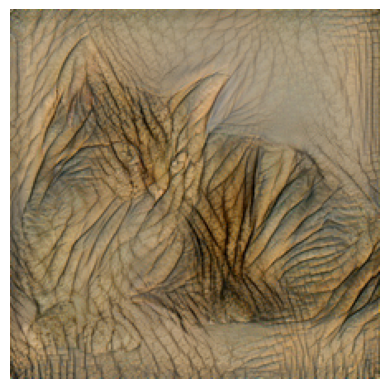

In [ ]:
cat_url = "https://github.com/rgeirhos/texture-vs-shape/blob/master/stimuli/style-transfer-preprocessed-512/cat/cat5-elephant2.png?raw=true"
cat_image = Image.open(requests.get(cat_url, stream=True).raw)
plt.imshow(cat_image)
plt.axis('off')
plt.show()

In [ ]:
cat_image = preprocess(cat_image).unsqueeze(0).to(device)

In [ ]:
text_inputs = clip.tokenize(["a photo of a cat", "a photo of an elephant"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(cat_image)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [ ]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
labels = ["cat", "elephant"]
for label, score in zip(labels, similarity[0].tolist()):
    print(f"Label: {label}, Score: {score:.4f}")

Label: cat, Score: 0.7090
Label: elephant, Score: 0.2910


Resnet Prediction

In [ ]:
cat_image_tensor = resnet_transform(cat_image).unsqueeze(0).to(device)
with torch.no_grad():
    resnet_output = fine_tuned_resnet(cat_image_tensor)
    predicted_class = resnet_output.argmax(dim=1).item()
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("ResNet prediction:", cifar10_classes[predicted_class])

ResNet prediction: bird


## Doing another example.
## Cat with Bear skin

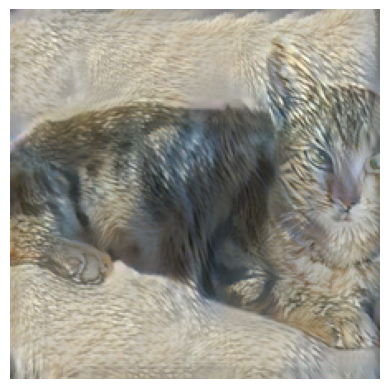

In [ ]:
cat_url_2 = "https://github.com/rgeirhos/texture-vs-shape/blob/master/stimuli/style-transfer-preprocessed-512/cat/cat3-bear2.png?raw=true"
cat_image_2 = Image.open(requests.get(cat_url_2, stream=True).raw)
plt.imshow(cat_image_2)
plt.axis('off')
plt.show()

In [ ]:
cat_image_2 = preprocess(cat_image_2).unsqueeze(0).to(device)

In [ ]:
text_inputs = clip.tokenize(["a photo of a cat", "a photo of a bear"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(cat_image_2)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
labels = ["cat", "bear"]
for label, score in zip(labels, similarity[0].tolist()):
    print(f"Label: {label}, Score: {score:.4f}")

Label: cat, Score: 0.9971
Label: bear, Score: 0.0029


ResNet Output

In [ ]:
cat_image_tensor_2 = resnet_transform(cat_image_2).unsqueeze(0).to(device)
with torch.no_grad():
    resnet_output = fine_tuned_resnet(cat_image_tensor_2)
    predicted_class = resnet_output.argmax(dim=1).item()
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("ResNet prediction:", cifar10_classes[predicted_class])

ResNet prediction: bird


## Final Example:
Chair with Cat's texture

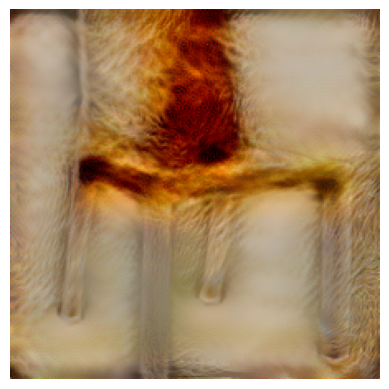

In [ ]:
chair_url = "https://github.com/rgeirhos/texture-vs-shape/blob/master/stimuli/style-transfer-preprocessed-512/chair/chair1-cat3.png?raw=true"
chair_image = Image.open(requests.get(chair_url, stream=True).raw)
plt.imshow(chair_image)
plt.axis('off')
plt.show()

In [ ]:
chair_image = preprocess(chair_image).unsqueeze(0).to(device)

In [ ]:
text_inputs = clip.tokenize(["a photo of a chair", "a photo of a cat"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(chair_image)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [ ]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
labels = ["chair", "cat"]
for label, score in zip(labels, similarity[0].tolist()):
    print(f"Label: {label}, Score: {score:.4f}")

Label: chair, Score: 0.8242
Label: cat, Score: 0.1755


ResNet Prediction

In [ ]:
chair_image_ten = resnet_transform(chair_image).unsqueeze(0).to(device)
with torch.no_grad():
    resnet_output = fine_tuned_resnet(chair_image_ten)
    predicted_cls = resnet_output.argmax(dim=1).item()
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("ResNet prediction:", cifar10_classes[predicted_cls])

ResNet prediction: bird


# 6. Robustness tests:


Loading CIFAR-10

In [ ]:
cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [ ]:
index = np.random.randint(0, len(cifar_test))
image, label = cifar_test[index]
class_names = cifar_test.classes

Displaying the image

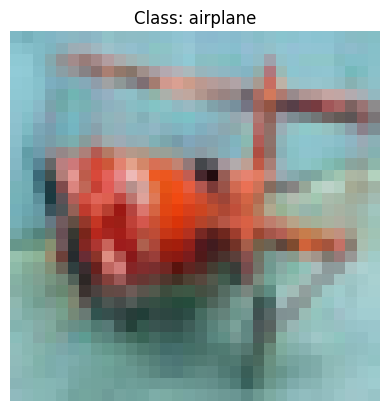

In [ ]:
plt.imshow(image)
plt.title(f"Class: {class_names[label]}")
plt.axis("off")
plt.show()

Cartooning Function

In [ ]:
import cv2

In [ ]:
def cartoonify(img_pil):
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cartoon = cv2.stylization(img, sigma_s=150, sigma_r=0.25)
    cartoon = cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB)
    return Image.fromarray(cartoon)

Gaussian Noise

In [ ]:
def gaussian_noise(img_pil, sigma=20):
    arr = np.array(img_pil).astype(np.float32)
    noise = np.random.normal(0, sigma, arr.shape).astype(np.float32)
    noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)


Sketch

In [ ]:
def sketchify(img_pil):
    arr = np.array(img_pil)
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    inv = 255 - gray
    blur = cv2.GaussianBlur(inv, (21, 21), 0)
    sketch = cv2.divide(gray, 255 - blur, scale=256)
    return Image.fromarray(sketch).convert("RGB")


In [ ]:
perturbations = {
    "original": lambda x:x,
    "gaussian_noise": lambda x: gaussian_noise(x),
    "blur": transforms.GaussianBlur(5),
    "brightness": transforms.ColorJitter(brightness=0.5),
    "hue": lambda x: transforms.functional.adjust_hue(x, 0.5),
    "posterize": transforms.RandomPosterize(bits=3),
    "cartoon": cartoonify,
    "sketch": sketchify
}

In [ ]:
text_prompts = [f"a photo of a {cifar_class}" for cifar_class in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


Visualization + Results

original: CLIP prediction: airplane, ResNet prediction: airplane
gaussian_noise: CLIP prediction: bird, ResNet prediction: airplane
blur: CLIP prediction: airplane, ResNet prediction: airplane
brightness: CLIP prediction: airplane, ResNet prediction: airplane
hue: CLIP prediction: airplane, ResNet prediction: airplane
posterize: CLIP prediction: airplane, ResNet prediction: airplane
cartoon: CLIP prediction: cat, ResNet prediction: airplane
sketch: CLIP prediction: dog, ResNet prediction: airplane


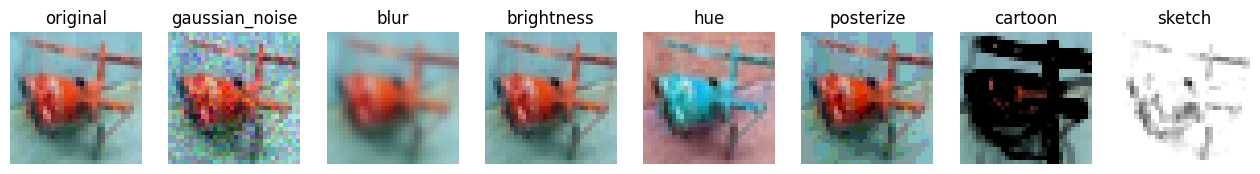

In [ ]:
fig, axes = plt.subplots(1, len(perturbations), figsize=(16, 4))
for i, (name, transformation) in enumerate(perturbations.items()):
    perturbed_image = transformation(image)
    axes[i].imshow(perturbed_image)
    axes[i].set_title(name)
    axes[i].axis("off")
    clip_input_image = preprocess(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(clip_input_image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    clip_prediction = class_names[similarity.argmax().item()]
    resnet_input_image = resnet_transform(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        resnet_output = fine_tuned_resnet(resnet_input_image)
        resnet_prediction = class_names[resnet_output.argmax(dim=1).item()]
    print(f"{name}: CLIP prediction: {clip_prediction}, ResNet prediction: {resnet_prediction}")
plt.show()

### Testing it for a high-quality image

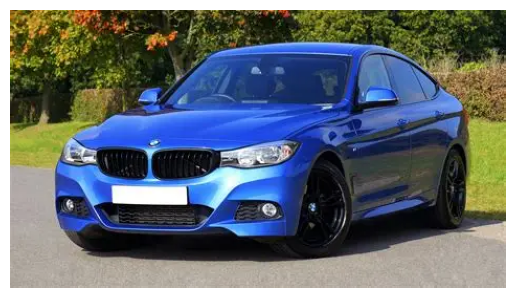

In [ ]:
car_url = "https://tse4.mm.bing.net/th/id/OIP.XQ6CyncXgEdljRssh_LAIwHaEK?rs=1&pid=ImgDetMain&o=7&rm=3"
car_image = Image.open(requests.get(car_url, stream=True).raw)
plt.imshow(car_image)
plt.axis('off')
plt.show()

In [ ]:
perturbations_car = {
    "original": lambda x:x,
    "gaussian_noise": lambda x: gaussian_noise(x, sigma=50),
    "blur": transforms.GaussianBlur(5),
    "brightness": transforms.ColorJitter(brightness=0.5),
    "hue": lambda x: transforms.functional.adjust_hue(x, 0.5),
    "posterize": transforms.RandomPosterize(bits=3),
    "cartoon": cartoonify,
    "sketch": sketchify
}

In [ ]:
text_prompts = [f"a photo of a {cifar_class}" for cifar_class in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


original: CLIP prediction: automobile, ResNet prediction: automobile
gaussian_noise: CLIP prediction: automobile, ResNet prediction: automobile
blur: CLIP prediction: automobile, ResNet prediction: automobile
brightness: CLIP prediction: automobile, ResNet prediction: automobile
hue: CLIP prediction: automobile, ResNet prediction: automobile
posterize: CLIP prediction: automobile, ResNet prediction: automobile
cartoon: CLIP prediction: automobile, ResNet prediction: bird
sketch: CLIP prediction: automobile, ResNet prediction: bird


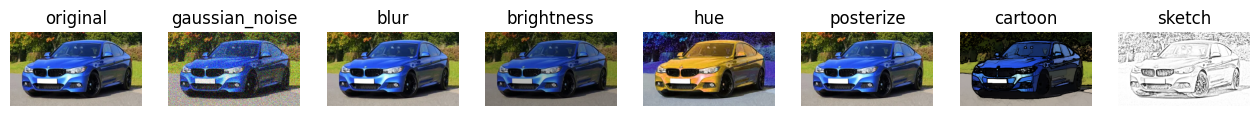

In [ ]:
fig, axes = plt.subplots(1, len(perturbations), figsize=(16, 4))
for i, (name, transformation) in enumerate(perturbations_car.items()):
    perturbed_image = transformation(car_image)
    axes[i].imshow(perturbed_image)
    axes[i].set_title(name)
    axes[i].axis("off")
    clip_input_image = preprocess(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(clip_input_image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    clip_prediction = class_names[similarity.argmax().item()]
    resnet_input_image = resnet_transform(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        resnet_output = fine_tuned_resnet(resnet_input_image)
        resnet_prediction = class_names[resnet_output.argmax(dim=1).item()]
    print(f"{name}: CLIP prediction: {clip_prediction}, ResNet prediction: {resnet_prediction}")
plt.show()

Another Image

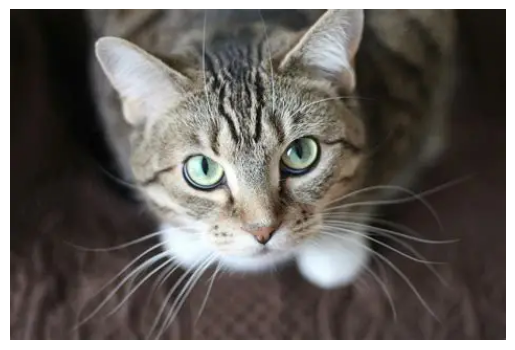

In [ ]:
cat_url = "https://tse1.mm.bing.net/th/id/OIP.1QN9rkUC3T3kmbnMfsnBIAHaE8?rs=1&pid=ImgDetMain&o=7&rm=3"
cat_image = Image.open(requests.get(cat_url, stream=True).raw)
plt.imshow(cat_image)
plt.axis('off')
plt.show()

In [ ]:
perturbations_cat = {
    "original": lambda x:x,
    "gaussian_noise": lambda x: gaussian_noise(x, sigma=50),
    "blur": transforms.GaussianBlur(5),
    "brightness": transforms.ColorJitter(brightness=0.5),
    "hue": lambda x: transforms.functional.adjust_hue(x, 0.5),
    "posterize": transforms.RandomPosterize(bits=3),
    "cartoon": cartoonify,
    "sketch": sketchify
}

In [ ]:
text_prompts = [f"a photo of a {cifar_class}" for cifar_class in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


original: CLIP prediction: cat, ResNet prediction: cat
gaussian_noise: CLIP prediction: cat, ResNet prediction: cat
blur: CLIP prediction: cat, ResNet prediction: cat
brightness: CLIP prediction: cat, ResNet prediction: cat
hue: CLIP prediction: cat, ResNet prediction: cat
posterize: CLIP prediction: cat, ResNet prediction: cat
cartoon: CLIP prediction: cat, ResNet prediction: bird
sketch: CLIP prediction: cat, ResNet prediction: bird


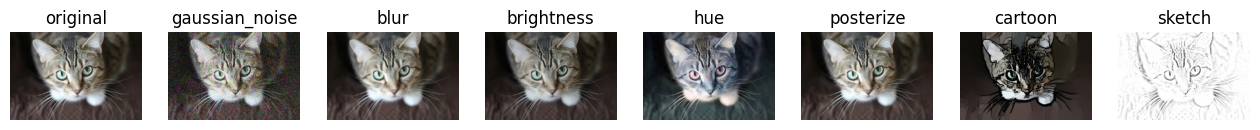

In [ ]:
fig, axes = plt.subplots(1, len(perturbations), figsize=(16, 4))
for i, (name, transformation) in enumerate(perturbations_cat.items()):
    perturbed_image = transformation(cat_image)
    axes[i].imshow(perturbed_image)
    axes[i].set_title(name)
    axes[i].axis("off")
    clip_input_image = preprocess(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(clip_input_image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    clip_prediction = class_names[similarity.argmax().item()]
    resnet_input_image = resnet_transform(perturbed_image).unsqueeze(0).to(device)
    with torch.no_grad():
        resnet_output = fine_tuned_resnet(resnet_input_image)
        resnet_prediction = class_names[resnet_output.argmax(dim=1).item()]
    print(f"{name}: CLIP prediction: {clip_prediction}, ResNet prediction: {resnet_prediction}")
plt.show()

This shows that for high-quality images CLIP gives the correct prediction and is robust to perturbations, while ResNet gets confused on cartoon and sketch versions.
For low-resolution images like CIFAR-10, the results were not consistent and more or less, they both produced the same no. of correct predictions.